# MiB RNA structure prediction using positive and negative evolutionary information

In [21]:
import random
import requests
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Extraction of sequences, creation of datasets and MSA calculation

In [23]:
def seqExtract(fileLocation):  #fileLocation better be in the same folder
    """Extract all the sequences from the stockholm file provided by Rfam"""
    fileIntermed = "allSeq.txt"
    fasta = open(fileIntermed, "w") 
    
    with open(fileLocation, "r") as stockMSA:
        lines = len(stockMSA.readlines()) #nbre of lines
        stockMSA.seek(0)
        allID = []
        for i in range(1, lines):
            line = stockMSA.readline()
            if not(line[0] == '#' or line[0] == "\n"):
                id_seq = [j for j in line.split(' ') if j != ''] # split line into [id, seq]
                finalID = ">"+id_seq[0]+"\n"
                finalSeq = id_seq[1].replace('-','')
                fasta.writelines([finalID, finalSeq])
    
    fasta.close()

    fileOutput, numSeq = seqCombination(fileIntermed, fileLocation)
    
    return fileOutput, numSeq

In [25]:
def seqCombination(fileName, fileLocation):
    """If sequences in multiple parts, combines them"""
    fileOutput = "ALLSEQ_" + fileLocation

    with open(fileName, "r") as seqFile:
        lines = len(seqFile.readlines()) #nbre of lines
        seqFile.seek(0)
        allID = []
        allSeq = []
        nbrSeq = 0
        for i in range(1, int(lines/2)):
            lineID = seqFile.readline()
            lineSeq = seqFile.readline()
            if not(lineID in allID):
                allID.append(lineID)
                allSeq.append(lineSeq.rstrip())
                nbrSeq += 1
            else:
                indexID = allID.index(lineID)
                allSeq[indexID] += lineSeq

    with open(fileOutput, "w") as outFile:
        for j in range(len(allID)):
            outFile.writelines([">"+str(j+1)+"_"+allID[j][1:], allSeq[j]])

    return fileOutput, nbrSeq

In [27]:
def randChoice(allSeqFile, seqNum, percent):
    """Create new file with a percentage of all the sequences"""
    randSeq = random.sample(range(1, seqNum), int(seqNum//(100/percent)))
    fileOutput = str(percent) + "PERCENT_" + allSeqFile[7:] 
    fastaRand = open(fileOutput, "w")
    
    with open(allSeqFile, "r") as fastaFull:
        lines = fastaFull.readlines()
        for i in range(0, len(lines), 2):
            seqIndex = lines[i].split('_')[0][1:]
            if (int(seqIndex) in randSeq):
                fastaRand.writelines([lines[i], lines[i+1]])
    
    fastaRand.close()
    
    return fileOutput, seqNum//(100/percent)

In [51]:
def msaCalc(seqFile):
    """Sends a FASTA file for MSA with Clustal Omega and automatically saves the result in the folder (actually just incredible)"""
    
    # Read the RNA sequence from a text file
    with open(seqFile, 'r') as file:
        sequences = file.read()
    
    # Submit the job to Clustal Omega for RNA
    submit_url = 'https://www.ebi.ac.uk/Tools/services/rest/clustalo/run'
    data = {
        'sequence': sequences,
        'email': 'simon.draguet@gmail.com',  # Mandatory and must be valid
        'outfmt': 'stockholm',
        'stype': 'rna'
    }
    submit_response = requests.post(submit_url, data=data)
    
    # Check the response
    if not submit_response.ok or '<error>' in submit_response.text:
        print("[ERROR] Submission failed:")
        print(submit_response.text)
        exit()
    
    job_id = submit_response.text.strip()
    print(f"[INFO] Job submitted with ID: {job_id}")
    
    # Check the job status
    status_url = f'https://www.ebi.ac.uk/Tools/services/rest/clustalo/status/{job_id}'
    while True:
        status_response = requests.get(status_url)
        status = status_response.text.strip()
        print(f"[INFO] Current status: {status}")
        if status == 'FINISHED':
            break
        elif status in ['ERROR', 'FAILURE', 'NOT_FOUND']:
            print(f"[ERROR] Job failed or not found: {status}")
            exit()
        time.sleep(5)
    
    # Retrieve the result
    result_url = f'https://www.ebi.ac.uk/Tools/services/rest/clustalo/result/{job_id}/aln-stockholm'
    result_response = requests.get(result_url)
    
    if result_response.ok:
        with open("MSA_" + seqFile, 'w') as f:
            f.write(result_response.text)
        print("[INFO] Aligned RNA result saved in '" + "MSA_" + seqFile + "'")
    else:
        print("[ERROR] Unable to retrieve the result:", result_response.text)


In [13]:
def allCalc(stockFile):
    """Just give stockholm file from Rfam and do different MSA with diff % of the number of sequences"""
    extraction = seqExtract(stockFile)
    nbrSeqPer = []
    for i in range(10,100,10):
        randomSeq = randChoice(extraction[0], extraction[1], i)
        nbrSeqPer.append(randomSeq)
        msaCalc(randomSeq[0])

    return nbrSeqPer

In [31]:
res = allCalc("RF01739.stockholm.txt")
print(res)

[INFO] Job soumis avec ID : clustalo-R20250512-145653-0821-23060843-p1m
[INFO] Statut actuel : QUEUED
[INFO] Statut actuel : RUNNING
[INFO] Statut actuel : RUNNING
[INFO] Statut actuel : FINISHED
[INFO] Résultat ARN aligné sauvegardé dans 'MSA_10PERCENT_RF01739.stockholm.txt'
[INFO] Job soumis avec ID : clustalo-R20250512-145722-0971-3822786-p1m
[INFO] Statut actuel : RUNNING
[INFO] Statut actuel : FINISHED
[INFO] Résultat ARN aligné sauvegardé dans 'MSA_20PERCENT_RF01739.stockholm.txt'
[INFO] Job soumis avec ID : clustalo-R20250512-145736-0760-95477775-p1m
[INFO] Statut actuel : RUNNING
[INFO] Statut actuel : FINISHED
[INFO] Résultat ARN aligné sauvegardé dans 'MSA_30PERCENT_RF01739.stockholm.txt'
[INFO] Job soumis avec ID : clustalo-R20250512-145757-0562-92726785-p1m
[INFO] Statut actuel : RUNNING
[INFO] Statut actuel : FINISHED
[INFO] Résultat ARN aligné sauvegardé dans 'MSA_40PERCENT_RF01739.stockholm.txt'
[INFO] Job soumis avec ID : clustalo-R20250512-145813-0986-71307663-p1m
[INF

In [103]:
randomSeq = randChoice("ALLSEQ_RF00005.stockholm.txt", 953, 50)
print(randomSeq)
msaCalc('50PERCENT_RF00005.stockholm.txt')

('50PERCENT_RF00005.stockholm.txt', 476.0)
[INFO] Job soumis avec ID : clustalo-R20250510-132853-0774-92674334-p1m
[INFO] Statut actuel : QUEUED
[INFO] Statut actuel : RUNNING
[INFO] Statut actuel : FINISHED
[INFO] Résultat ARN aligné sauvegardé dans 'MSA_50PERCENT_RF00005.stockholm.txt'


Occurence of genes among datasets

In [7]:
def occGenes(fileLocation):
    with open(fileLocation, "r") as seqFile:
            lines = len(seqFile.readlines()) #nbre of lines
            seqFile.seek(0)
            allID = []
            occID = []
            for i in range(1, lines):
                line = seqFile.readline()
                if line[0] == '>':
                    idName = line.split('_')[1]
                    geneName = idName.split('/')[0]
                    if not(geneName in allID):
                        allID.append(geneName)
                        occID.append(1)
                    else:
                        occID[allID.index(geneName)] += 1

    outID = []
    outOcc = []
    for j in range(len(occID)):
        if occID[j] > 2: # can be modified
            outID.append(allID[j])
            outOcc.append(occID[j])
    return [outID, outOcc]

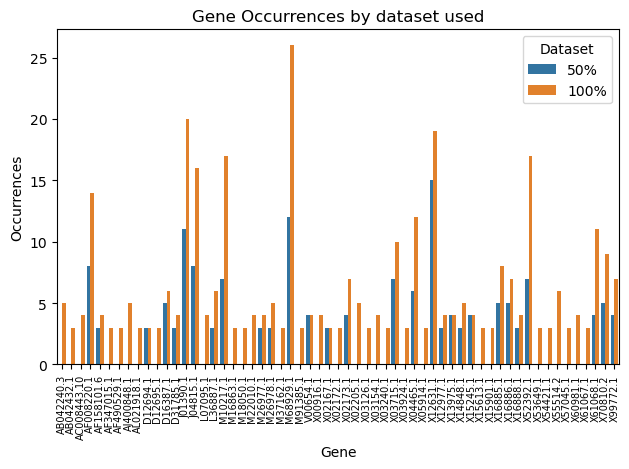

In [21]:
dataSet1 = occGenes("50PERCENT_RF00005.stockholm.txt") #changed manually
dataSet2 = occGenes("ALLSEQ_RF00005.stockholm.txt") #changed manually

# Example input data
data1 = {'Gene': dataSet1[0], 'Occurrences': dataSet1[1], 'Dataset': '50%'}
data2 = {'Gene': dataSet2[0], 'Occurrences': dataSet2[1], 'Dataset': '100%'}

df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)

# Combine and ensure all genes are represented
df = pd.concat([df1, df2], ignore_index=True)

# Fill missing combinations with 0 (optional depending on how you want to handle absence)
all_genes = df['Gene'].unique()
all_datasets = df['Dataset'].unique()

# Pivot then unpivot to ensure all gene-dataset pairs exist
pivoted = df.pivot_table(index='Gene', columns='Dataset', values='Occurrences', fill_value=0)
df_full = pivoted.reset_index().melt(id_vars='Gene', var_name='Dataset', value_name='Occurrences')

# Optional: sort so smaller bars come first for visual clarity (only matters if overlaying bars)
df_full['sort_order'] = df_full.groupby('Gene')['Occurrences'].rank(method='first')
df_full = df_full.sort_values(['Gene', 'sort_order'])

# Plot
sns.barplot(data=df_full, x='Gene', y='Occurrences', hue='Dataset', dodge=True)
plt.title('Gene Occurrences by dataset used')
plt.xticks(rotation=90, fontsize=7)
plt.tight_layout()
plt.show()
